#Dog breed identification
##Guillermo Blanco Núñez
####UDC International Summer School - Data Mining and Neural Networks Course
July 24th, 2025

Load dataset from github repository, downloaded from public kaggle competition before.  

In [4]:
!git clone --depth 1 https://github.com/GuillermoBlancoNunez/DogBreedsDataRepo.git
%cd DogBreedsDataRepo


Cloning into 'DogBreedsDataRepo'...
remote: Enumerating objects: 20496, done.
remote: Counting objects: 100% (20496/20496), done.
remote: Compressing objects: 100% (20496/20496), done.
remote: Total 20496 (delta 0), reused 20496 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (20496/20496), 684.99 MiB | 4.90 MiB/s, done.
Updating files: 100% (20581/20581), done.
/content/DogBreedsDataRepo


Import all necessary libraries and set variables for path, showing the amount of images loaded in the training dataset.

In [5]:
import pandas as pd
import numpy as np
import glob, re
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

DATA_DIR = Path("/content/DogBreedsDataRepo")  # Adjust path
IMG_DIR = DATA_DIR / "train"                  #For training set
image_paths = sorted(glob.glob(str(IMG_DIR / "*.jpg")))
print("Total de imágenes encontradas:", len(image_paths))


Total de imágenes encontradas: 10222


Read labels.csv to create an index from image labels to the dog breed they reference.

In [6]:
labels_df = pd.read_csv("/content/DogBreedsDataRepo/labels.csv")

id_col    = [c for c in labels_df.columns if c.lower() in ("id","image_id","label","image")][0]
breed_col = [c for c in labels_df.columns if "breed" in c.lower()][0]

print("id_col =", id_col, "| breed_col =", breed_col)

id2breed = dict(zip(labels_df[id_col].astype(str),
                    labels_df[breed_col].astype(str)))

id_col = id | breed_col = breed


Connects indexes between labels.csv and image labels

In [7]:

def extract_label(path: str):
    """
    Returns the breed associated with the image path according to labels.csv.
    Requires a global dictionary id2breed: {image_id: breed}.
    If image_id isn´t found in the dictionary, returns 'UNKNOWN'.
    """
    image_id = Path(path).stem  # name without .jpg extension
    return id2breed.get(image_id, "UNKNOWN")




# Generates a list of breeds, not IDs
breeds = [extract_label(p) for p in image_paths]

Creates a pandas dataframe with the image path, the filename and the breed name as the label.

In [8]:
df = pd.DataFrame({
    "path": image_paths,
    "filename": [Path(p).name for p in image_paths],
    "breed": breeds
})

df.head()


,path,filename,breed
0,/content/DogBreedsDataRepo/train/000bec180eb18...,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,/content/DogBreedsDataRepo/train/001513dfcb2ff...,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,/content/DogBreedsDataRepo/train/001cdf01b096e...,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,/content/DogBreedsDataRepo/train/00214f311d5d2...,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,/content/DogBreedsDataRepo/train/0021f9ceb3235...,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


Check nº of breeds detected in data, and the breed with the least and most apperances.

In [9]:
classes = df['breed'].unique()
NUM_CLASSES = len(classes)
label2idx = {breed:idx for idx, breed in enumerate(classes)}
print("Nº of detected breeds:", NUM_CLASSES)
counts = df['breed'].value_counts()
print(f"Breed with the most images: {counts.idxmax()} with {counts.max()}")
print(f"Breed with the least images: {counts.idxmin()} with {counts.min()}")

Nº of detected breeds: 120
Breed with the most images: scottish_deerhound with 126
Breed with the least images: eskimo_dog with 66


In [10]:



FRACTION = 0.5
RANDOM_STATE = 42

print("Total original:", len(df))


df = (
    df
    .groupby('breed', group_keys=False)        # agrupa por raza…
    .apply(lambda grp: grp.sample(
        frac=FRACTION,
        random_state=RANDOM_STATE
    ))
    .reset_index(drop=True)
)

# Verifica

print("Total subsample:", len(df))
print("Distribución subsample:")
print(df['breed'].value_counts().head())




Total original: 10222
Total subsample: 5118
Distribución subsample:
breed
scottish_deerhound      63
afghan_hound            58
maltese_dog             58
entlebucher             58
bernese_mountain_dog    57
Name: count, dtype: int64


/tmp/ipython-input-10-524071218.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(


Separate into training, validation and testing set. With 70/15/15 split.

In [11]:

SEED = 42

# Separate testing set (15%)
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df["breed"], random_state=SEED)

# Separate a global 15% for validate set from the 85% remaining

val_rel = 0.15 / 0.85

train_df, val_df = train_test_split(train_val_df, test_size=val_rel, stratify=train_val_df['breed'], random_state=SEED)

print(f"Tamaños -> Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Tamaños -> Train: 3582 | Val: 768 | Test: 768


Statistics for training, validation and testing sets.

In [12]:
subsets = {"Training set": train_df, "Validation set": val_df, "Test set": test_df}
for name, i in subsets.items():
  print(f"\n\n\nStatisctics for {name}")
  num_classes = i['breed'].nunique()
  print(f"Nº of entries: {len(i)}")
  print("Nº of detected breeds:", num_classes)
  counts = i['breed'].value_counts()

  print(f"Breed with the most images: {counts.idxmax()} with {counts.max()}")
  print(f"Breed with the least images: {counts.idxmin()} with {counts.min()}")
  print(f"Ratio: {counts.max() / counts.min()}")






Statisctics for Training set
Nº of entries: 3582
Nº of detected breeds: 120
Breed with the most images: scottish_deerhound with 44
Breed with the least images: eskimo_dog with 23
Ratio: 1.9130434782608696



Statisctics for Validation set
Nº of entries: 768
Nº of detected breeds: 120
Breed with the most images: scottish_deerhound with 10
Breed with the least images: border_collie with 5
Ratio: 2.0



Statisctics for Test set
Nº of entries: 768
Nº of detected breeds: 120
Breed with the most images: scottish_deerhound with 9
Breed with the least images: otterhound with 5
Ratio: 1.8


In [13]:
IMG_SIZE = 224
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(paths, labels, batch_size, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(paths), seed=42)
    ds = ds.map(
        lambda p,y: (
            tf.keras.applications.efficientnet.preprocess_input(
                tf.image.resize(
                    tf.image.decode_jpeg(tf.io.read_file(p), channels=3),
                    (IMG_SIZE, IMG_SIZE)
                )
            ), y
        ),
        num_parallel_calls=AUTOTUNE
    )
    if training:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.08),
            tf.keras.layers.RandomZoom(0.1),
            tf.keras.layers.RandomContrast(0.1),
        ])
        ds = ds.map(lambda x,y: (aug(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    return ds.batch(batch_size).prefetch(AUTOTUNE)

def build_model(lr, l2_lambda=3e-4):
    base = tf.keras.applications.EfficientNetB0(
        include_top=False, weights="imagenet",
        input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling="avg"
    )
    base.trainable = False
    inputs  = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
    x       = base(inputs, training=False)
    x       = tf.keras.layers.Dropout(0.6)(x)
    outputs = tf.keras.layers.Dense(
        NUM_CLASSES, activation="softmax",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [14]:
# Configuraciones a probar
configs = [
    (0.002,  5, 32),
    (0.002,  5, 64),
    (0.001,  10, 32),
    (0.001,  10, 64),
    (0.0007, 15, 32),
    (0.0007, 15, 64),
    (0.0003, 20, 32),
    (0.0003, 20, 64),
]

# Preparamos test set (etiquetas e imágenes)
y_test_idx = test_df['breed'].map(label2idx).values
test_paths = test_df['path'].values

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 518ms/step - accuracy: 0.2112 - loss: 3.9522 - val_accuracy: 0.7591 - val_loss: 1.3167
Epoch 2/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 371ms/step - accuracy: 0.6880 - loss: 1.4289 - val_accuracy: 0.8034 - val_loss: 0.9571
Epoch 3/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 375ms/step - accuracy: 0.7813 - loss: 1.0404 - val_accuracy: 0.8281 - val_loss: 0.8826
Epoch 4/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 376ms/step - accuracy: 0.8253 - loss: 0.9039 - val_accuracy: 0.8255 - val_loss: 0.8535
Epoch 5/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 384ms/step - accuracy: 0.8518 - loss: 0.8139 - val_accuracy: 0.8281 - val_loss: 0.8621


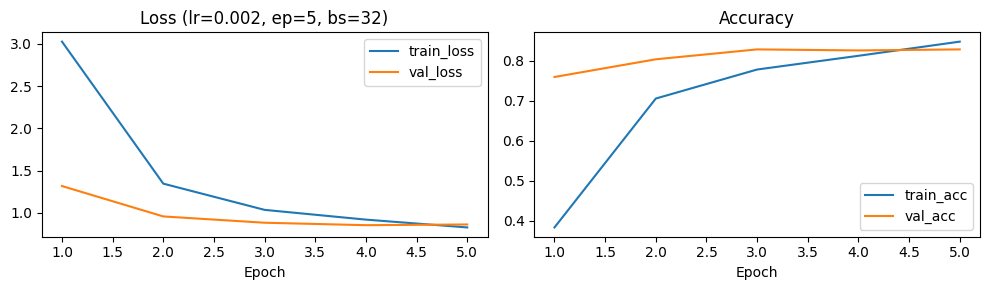

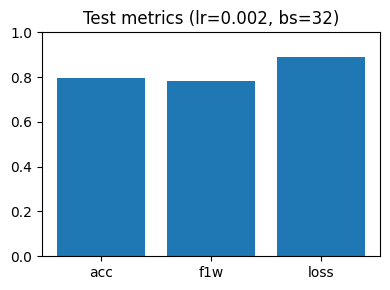

Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.1470 - loss: 4.2083 - val_accuracy: 0.7318 - val_loss: 1.6585
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 768ms/step - accuracy: 0.6731 - loss: 1.6864 - val_accuracy: 0.7956 - val_loss: 1.0506
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 751ms/step - accuracy: 0.7746 - loss: 1.1606 - val_accuracy: 0.8255 - val_loss: 0.8969
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 763ms/step - accuracy: 0.8190 - loss: 0.9544 - val_accuracy: 0.8242 - val_loss: 0.8380
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 767ms/step - accuracy: 0.8378 - loss: 0.8697 - val_accuracy: 0.8333 - val_loss: 0.8141


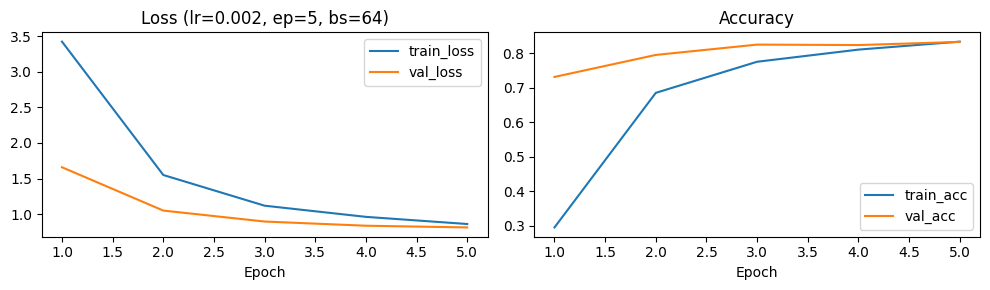

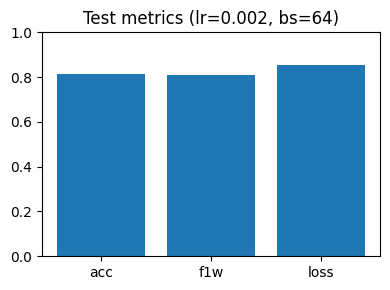

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 87s 589ms/step - accuracy: 0.1067 - loss: 4.3835 - val_accuracy: 0.6979 - val_loss: 2.1510
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 47s 416ms/step - accuracy: 0.5832 - loss: 2.1379 - val_accuracy: 0.7643 - val_loss: 1.3082
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 380ms/step - accuracy: 0.7239 - loss: 1.4177 - val_accuracy: 0.8034 - val_loss: 1.0382
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 379ms/step - accuracy: 0.7852 - loss: 1.1109 - val_accuracy: 0.8203 - val_loss: 0.9240
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 371ms/step - accuracy: 0.8064 - loss: 0.9877 - val_accuracy: 0.8177 - val_loss: 0.8686
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 375ms/step - accuracy: 0.8237 - loss: 0.8928 - val_accuracy: 0.8190 - val_loss: 0.8339
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 376ms/step - accuracy: 0.8580 - loss: 0.8182 - val_accuracy: 0.8268 - val_loss: 0.8116
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 384ms/step - accuracy: 0.8788 - loss: 0

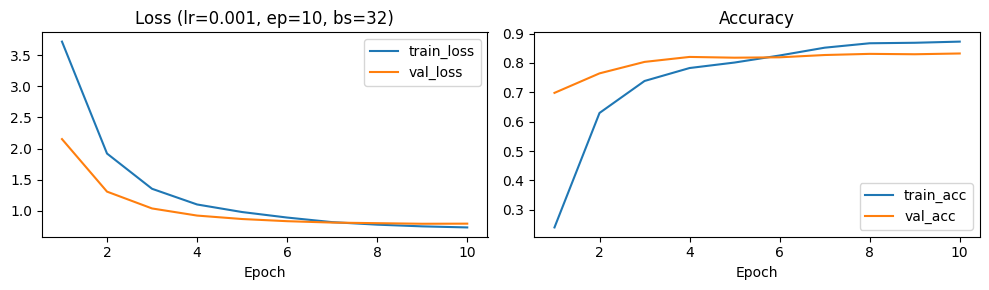

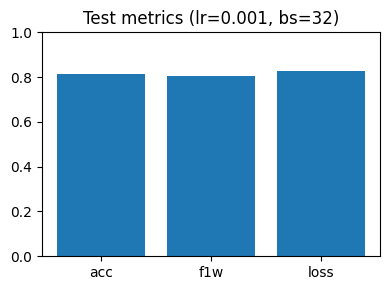

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 993ms/step - accuracy: 0.0744 - loss: 4.5890 - val_accuracy: 0.6094 - val_loss: 2.7454
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 768ms/step - accuracy: 0.5017 - loss: 2.6197 - val_accuracy: 0.7422 - val_loss: 1.6865
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 763ms/step - accuracy: 0.6728 - loss: 1.7469 - val_accuracy: 0.7852 - val_loss: 1.2642
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 743ms/step - accuracy: 0.7537 - loss: 1.3518 - val_accuracy: 0.7995 - val_loss: 1.0679
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 749ms/step - accuracy: 0.7765 - loss: 1.1799 - val_accuracy: 0.8099 - val_loss: 0.9629
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 751ms/step - accuracy: 0.7975 - loss: 1.0620 - val_accuracy: 0.8138 - val_loss: 0.9020
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 752ms/step - accuracy: 0.8260 - loss: 0.9412 - val_accuracy: 0.8216 - val_loss: 0.8569
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 769ms/step - accuracy: 0.8441 - loss: 0.8630 - val_accu

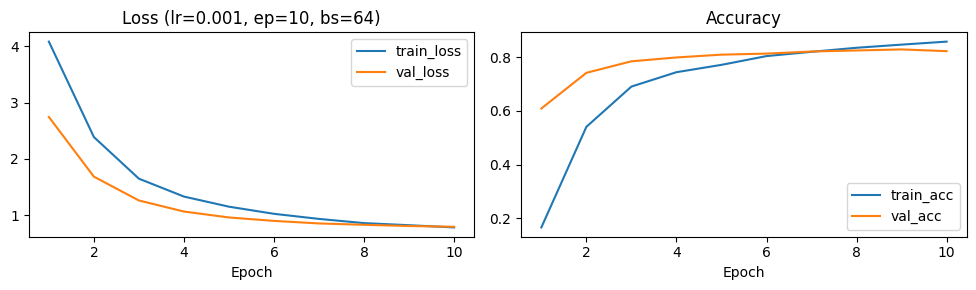

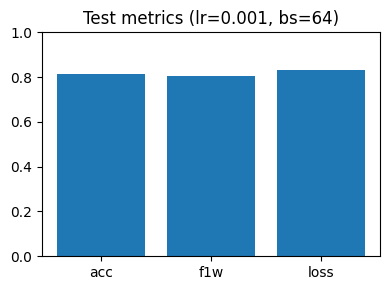

Epoch 1/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 76s 495ms/step - accuracy: 0.0710 - loss: 4.5574 - val_accuracy: 0.6510 - val_loss: 2.6981
Epoch 2/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 382ms/step - accuracy: 0.5123 - loss: 2.6504 - val_accuracy: 0.7630 - val_loss: 1.6739
Epoch 3/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 387ms/step - accuracy: 0.6704 - loss: 1.7700 - val_accuracy: 0.8034 - val_loss: 1.2588
Epoch 4/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 376ms/step - accuracy: 0.7321 - loss: 1.3624 - val_accuracy: 0.8151 - val_loss: 1.0650
Epoch 5/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 372ms/step - accuracy: 0.7779 - loss: 1.1606 - val_accuracy: 0.8242 - val_loss: 0.9607
Epoch 6/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 384ms/step - accuracy: 0.7979 - loss: 1.0301 - val_accuracy: 0.8190 - val_loss: 0.8997
Epoch 7/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 392ms/step - accuracy: 0.8194 - loss: 0.9578 - val_accuracy: 0.8268 - val_loss: 0.8551
Epoch 8/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 80s 377ms/step - accuracy: 0.8387 - loss: 0

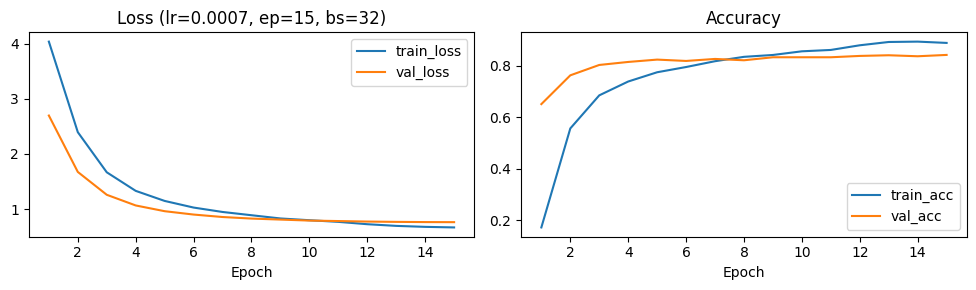

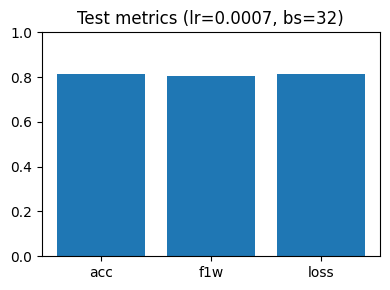

Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.0486 - loss: 4.6943 - val_accuracy: 0.5404 - val_loss: 3.2497
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 749ms/step - accuracy: 0.3907 - loss: 3.1532 - val_accuracy: 0.7057 - val_loss: 2.2017
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 748ms/step - accuracy: 0.5881 - loss: 2.2655 - val_accuracy: 0.7526 - val_loss: 1.6359
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 751ms/step - accuracy: 0.6916 - loss: 1.7332 - val_accuracy: 0.7799 - val_loss: 1.3315
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 755ms/step - accuracy: 0.7279 - loss: 1.4476 - val_accuracy: 0.7969 - val_loss: 1.1507
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 769ms/step - accuracy: 0.7673 - loss: 1.2583 - val_accuracy: 0.8125 - val_loss: 1.0420
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 786ms/step - accuracy: 0.7828 - loss: 1.1234 - val_accuracy: 0.8177 - val_loss: 0.9677
Epoch 8/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 752ms/step - accuracy: 0.8196 - loss: 1.0243 - val_accurac

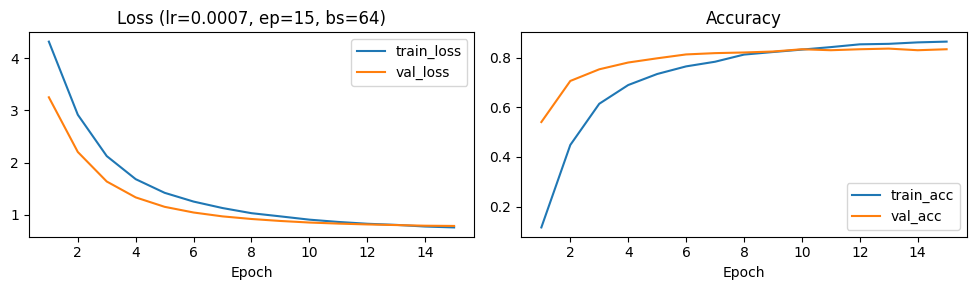

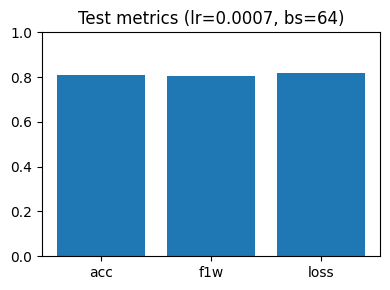

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 84s 562ms/step - accuracy: 0.0326 - loss: 4.7894 - val_accuracy: 0.3906 - val_loss: 3.7736
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 51s 377ms/step - accuracy: 0.2639 - loss: 3.7239 - val_accuracy: 0.5911 - val_loss: 2.9133
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 381ms/step - accuracy: 0.4456 - loss: 2.9613 - val_accuracy: 0.6992 - val_loss: 2.3081
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 388ms/step - accuracy: 0.5699 - loss: 2.3902 - val_accuracy: 0.7422 - val_loss: 1.8940
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 381ms/step - accuracy: 0.6488 - loss: 2.0070 - val_accuracy: 0.7630 - val_loss: 1.6104
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 382ms/step - accuracy: 0.7070 - loss: 1.7376 - val_accuracy: 0.7799 - val_loss: 1.4144
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 386ms/step - accuracy: 0.7400 - loss: 1.5348 - val_accuracy: 0.7943 - val_loss: 1.2729
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 378ms/step - accuracy: 0.7576 - loss: 1

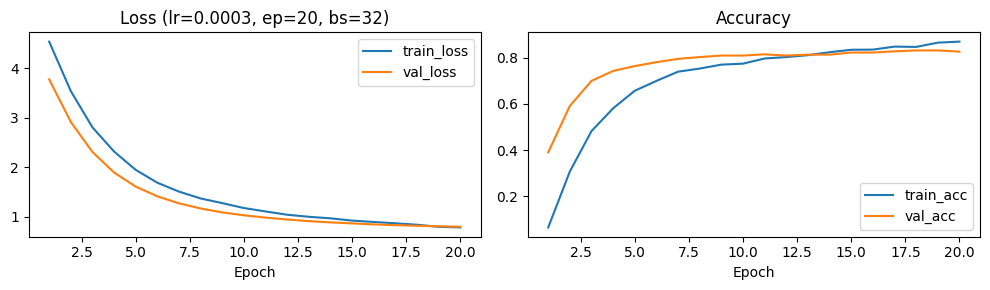

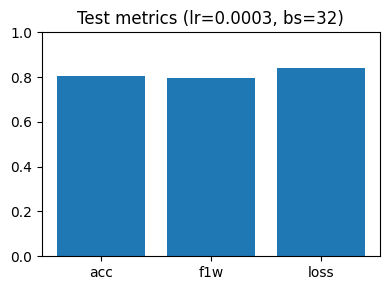

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 989ms/step - accuracy: 0.0155 - loss: 4.9214 - val_accuracy: 0.2513 - val_loss: 4.1513
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 756ms/step - accuracy: 0.1333 - loss: 4.1248 - val_accuracy: 0.4844 - val_loss: 3.4695
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 763ms/step - accuracy: 0.3160 - loss: 3.4834 - val_accuracy: 0.6055 - val_loss: 2.9189
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 781ms/step - accuracy: 0.4446 - loss: 2.9758 - val_accuracy: 0.6602 - val_loss: 2.4817
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 796ms/step - accuracy: 0.5457 - loss: 2.5797 - val_accuracy: 0.7083 - val_loss: 2.1424
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 747ms/step - accuracy: 0.6030 - loss: 2.2650 - val_accuracy: 0.7344 - val_loss: 1.8818
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 772ms/step - accuracy: 0.6414 - loss: 2.0089 - val_accuracy: 0.7656 - val_loss: 1.6794
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 743ms/step - accuracy: 0.6743 - loss: 1.8211 - val_accu

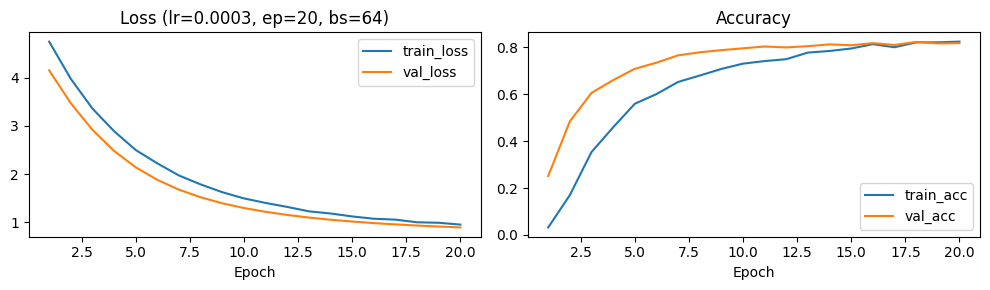

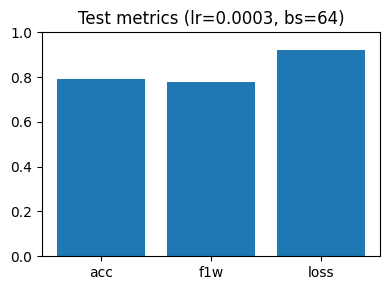

    lr  epochs  batch_size  test_loss  test_acc  test_f1_weighted                   model_file
0.0020       5          32   0.890785  0.794271          0.784284   cnn_lr0.002_ep5_bs32.keras
0.0020       5          64   0.854059  0.813802          0.808083   cnn_lr0.002_ep5_bs64.keras
0.0010      10          32   0.828719  0.812500          0.805491  cnn_lr0.001_ep10_bs32.keras
0.0010      10          64   0.829831  0.812500          0.807193  cnn_lr0.001_ep10_bs64.keras
0.0007      15          32   0.814895  0.812500          0.806502 cnn_lr0.0007_ep15_bs32.keras
0.0007      15          64   0.820036  0.809896          0.803154 cnn_lr0.0007_ep15_bs64.keras
0.0003      20          32   0.839535  0.803385          0.797112 cnn_lr0.0003_ep20_bs32.keras
0.0003      20          64   0.920145  0.790365          0.780002 cnn_lr0.0003_ep20_bs64.keras


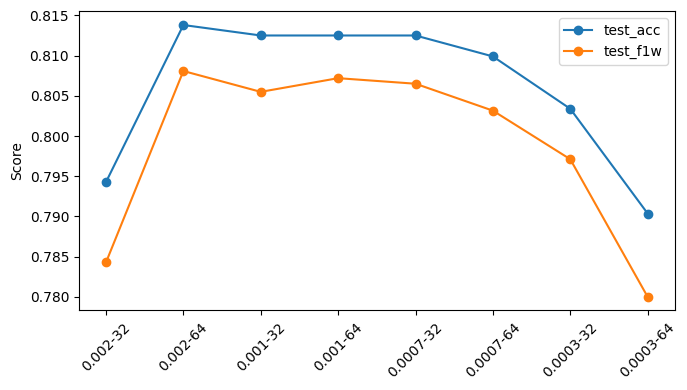

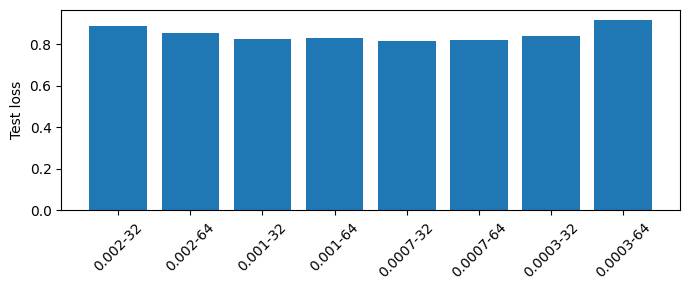

In [15]:



results = []

for lr, epochs, batch_size in configs:
    # Datasets
    train_ds = make_dataset(train_df['path'].values,
                            train_df['breed'].map(label2idx).values,
                            batch_size, training=True)
    val_ds   = make_dataset(val_df['path'].values,
                            val_df['breed'].map(label2idx).values,
                            batch_size, training=False)
    test_ds  = make_dataset(test_paths, y_test_idx,
                            batch_size, training=False)

    # Modelo
    model = build_model(lr)

    early = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=2, min_delta = 1e-3, restore_best_weights=True
    )

    # Entrenamiento
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early],
        verbose=1
    )

    # ===== Gráficas por configuración =====
    ep = range(1, len(history.history['loss']) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].plot(ep, history.history["loss"],     label="train_loss")
    ax[0].plot(ep, history.history["val_loss"], label="val_loss")
    ax[0].set_title(f"Loss (lr={lr}, ep={epochs}, bs={batch_size})")
    ax[0].set_xlabel("Epoch"); ax[0].legend()

    ax[1].plot(ep, history.history["accuracy"],     label="train_acc")
    ax[1].plot(ep, history.history["val_accuracy"], label="val_acc")
    ax[1].set_title("Accuracy"); ax[1].set_xlabel("Epoch"); ax[1].legend()
    plt.tight_layout(); plt.show()

    # Evaluación en test
    loss, acc = model.evaluate(test_ds, verbose=0)
    probs     = model.predict(test_ds, verbose=0)
    preds     = np.argmax(probs, axis=1)
    f1w       = f1_score(y_test_idx, preds, average='weighted')

    # Mini gráfico de barras de test
    plt.figure(figsize=(4,3))
    plt.bar(["acc","f1w","loss"], [acc, f1w, loss])
    plt.title(f"Test metrics (lr={lr}, bs={batch_size})")
    plt.ylim(0,1); plt.tight_layout(); plt.show()

    # Guardar modelo
    model_path = f"cnn_lr{lr}_ep{epochs}_bs{batch_size}.keras"
    model.save(model_path)

    # Registrar resultado
    results.append({
        "lr": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "test_loss": loss,
        "test_acc": acc,
        "test_f1_weighted": f1w,
        "model_file": model_path
    })

# ===== Tabla final (una sola vez) =====
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))
df_results.to_csv("results_cnn.csv", index=False)

# ===== Gráficos comparativos finales =====
xlabels = df_results["lr"].astype(str) + "-" + df_results["batch_size"].astype(str)

plt.figure(figsize=(7,4))
plt.plot(xlabels, df_results["test_acc"], marker="o", label="test_acc")
plt.plot(xlabels, df_results["test_f1_weighted"], marker="o", label="test_f1w")
plt.xticks(rotation=45); plt.ylabel("Score"); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3))
plt.bar(xlabels, df_results["test_loss"])
plt.xticks(rotation=45); plt.ylabel("Test loss"); plt.tight_layout()
plt.show()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Extrayendo embeddings...
Listo. Shapes: (2148, 1280) (461, 1280) (461, 1280)


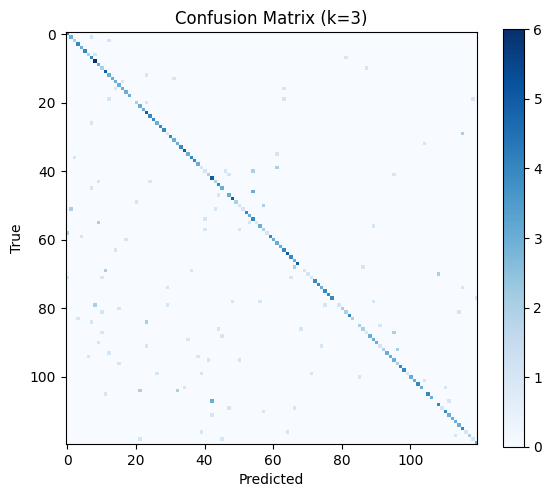

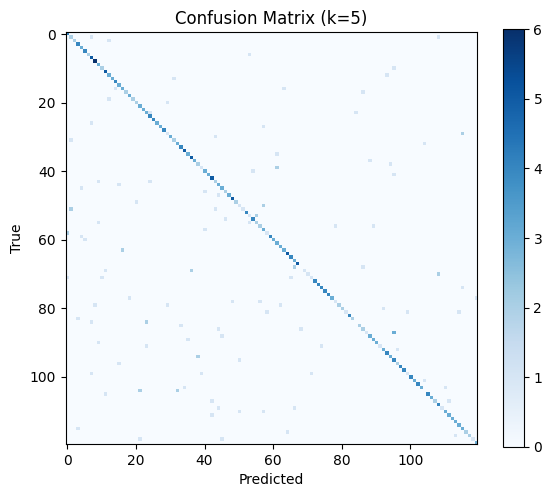

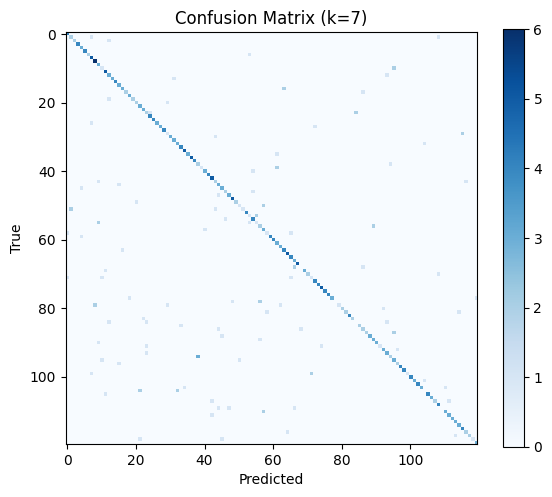

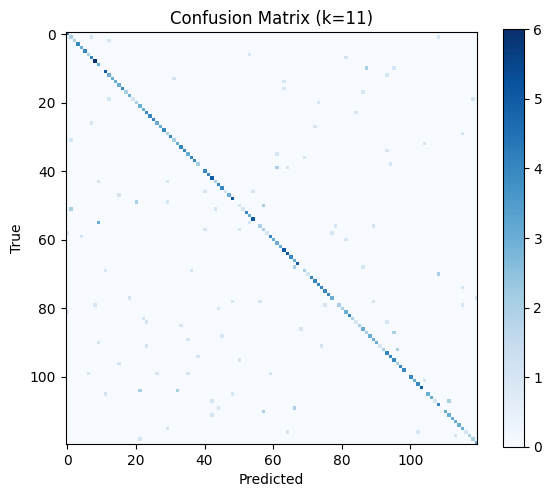

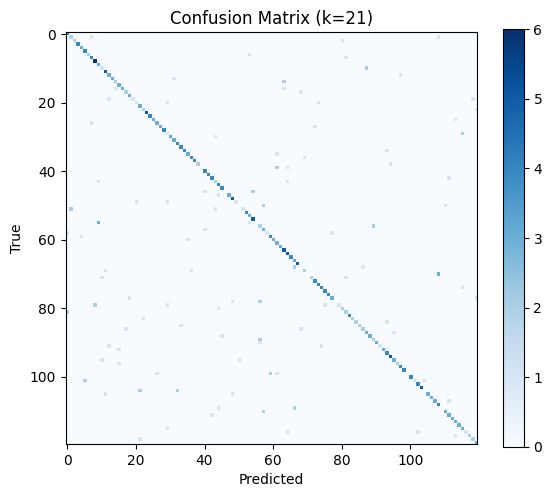

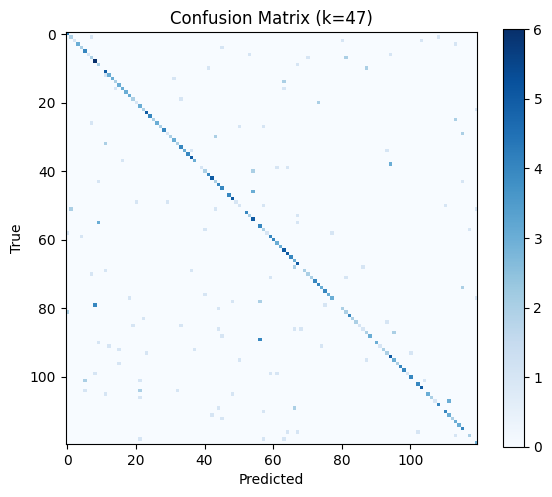

 k  train_acc  train_loss  val_acc  val_loss  test_acc  test_loss  test_f1_weighted
 3   0.862197    0.137803 0.715835  0.284165  0.731020   0.268980          0.707429
 5   0.832868    0.167132 0.746204  0.253796  0.739696   0.260304          0.727712
 7   0.806331    0.193669 0.744035  0.255965  0.746204   0.253796          0.731963
11   0.790037    0.209963 0.754881  0.245119  0.752711   0.247289          0.728358
21   0.766760    0.233240 0.741866  0.258134  0.735358   0.264642          0.708782
47   0.705307    0.294693 0.709328  0.290672  0.681128   0.318872          0.642680
Modelos KNN guardados en knn_models.pkl


In [ ]:
IMG_SIZE = 224
BATCH    = 64
AUTOTUNE = tf.data.AUTOTUNE
K_LIST   = [3, 5, 7, 11, 21, 47]

# ---------- 1. Dataset para extraer features (sin augment) ----------
def make_ds(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(
        lambda p,y: (
            tf.keras.applications.efficientnet.preprocess_input(
                tf.image.resize(
                    tf.image.decode_jpeg(tf.io.read_file(p), channels=3),
                    (IMG_SIZE, IMG_SIZE)
                )
            ), y
        ),
        num_parallel_calls=AUTOTUNE
    )
    return ds.batch(BATCH).prefetch(AUTOTUNE)

# ---------- 2. Feature extractor ----------
base = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='avg'
)
feat_extractor = tf.keras.Model(base.input, base.output)  # vector de 1280 dims

def extract_feats(df_split):
    ds = make_ds(df_split['path'].values,
                 df_split['breed'].map(label2idx).values)
    feats = []
    labs  = []
    for x,y in ds:
        feats.append(feat_extractor(x, training=False).numpy())
        labs.append(y.numpy())
    return np.vstack(feats), np.hstack(labs)

print("Extrayendo embeddings...")
X_train, y_train = extract_feats(train_df)
X_val,   y_val   = extract_feats(val_df)
X_test,  y_test  = extract_feats(test_df)
print("Listo. Shapes:", X_train.shape, X_val.shape, X_test.shape)

# ---------- 3. Entrenar / evaluar KNN para cada k ----------
rows = []
models = {}

for k in K_LIST:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train, y_train)

    # Train metrics
    y_tr_pred = knn.predict(X_train)
    acc_tr = accuracy_score(y_train, y_tr_pred)
    loss_tr = 1 - acc_tr

    # Val metrics
    y_val_pred = knn.predict(X_val)
    acc_val = accuracy_score(y_val, y_val_pred)
    loss_val = 1 - acc_val

    # Test metrics (para la tabla final)
    y_te_pred = knn.predict(X_test)
    acc_te = accuracy_score(y_test, y_te_pred)
    loss_te = 1 - acc_te
    f1w_te = f1_score(y_test, y_te_pred, average='weighted')

    rows.append([k, acc_tr, loss_tr, acc_val, loss_val, acc_te, loss_te, f1w_te])
    models[k] = knn  # guardar

    # Confusion matrix (test)
    cm = confusion_matrix(y_test, y_te_pred)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f'Confusion Matrix (k={k})')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# ---------- 4. Tabla de resultados ----------
cols = ["k",
        "train_acc","train_loss",
        "val_acc","val_loss",
        "test_acc","test_loss","test_f1_weighted"]
df_knn = pd.DataFrame(rows, columns=cols)
print(df_knn.to_string(index=False))

# ---------- 5. Guardar modelos ----------
with open("knn_models.pkl", "wb") as f:
    pickle.dump({"models": models,
                 "label2idx": label2idx}, f)
print("Modelos KNN guardados en knn_models.pkl")